In [66]:
from pathlib import Path
import numpy as np
import torch

TRAIN_FILEPATH = "/Users/33783/Desktop/capgemini/hackathon-mines-invent-2024/DATA/TRAIN"
TEST_FILEPATH = "/Users/33783/Desktop/capgemini/hackathon-mines-invent-2024/DATA/TEST"

BATCH_SIZE = 8

In [67]:
from baseline.dataset import BaselineDataset, BaselineDatatest
from baseline.collate import pad_collate

data_train_folder = Path(TRAIN_FILEPATH)
data_test_folder = Path(TEST_FILEPATH)

# Set seeds for PyTorch and numpy
torch.manual_seed(1234)
np.random.seed(1234)

dt_train = BaselineDataset(Path(data_train_folder))

# Split dataset: 80% train, 20% test
train_size = int(0.1 * len(dt_train))
val_size = len(dt_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dt_train, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate, shuffle=True
    )
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate, shuffle=False
    )

x_train, y_train = train_loader.__iter__().__next__()

for k, v in x_train.items():
    print(k,v.shape)
print("y", y_train.shape)

Reading patch metadata ...
Done.
Dataset ready.
S2 torch.Size([8, 61, 10, 128, 128])
date torch.Size([8, 61, 5])
TILE torch.Size([8, 6])
N_Parcel torch.Size([8, 1])
Parcel_Cover torch.Size([8, 1])
y torch.Size([8, 128, 128])


In [71]:
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import torch.nn.functional as F

from unet.model import UNET

MODEL_PATH = Path("models") / 'unet.pth'
LOAD_MODEL = True
IMG_HEIGHT = 128  
IMG_WIDTH = 128  
LEARNING_RATE = 0.0005
EPOCHS = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
def preprocess_batch_august(input_batch):
    """
    Here we want to use the collapse the temporal dimension of the input
    batch by keeping only the first image of the month of august

    input_batch: dataloader X dict batch
    """

    L= []
    for i in range(input_batch["date"].shape[0]):
        L.append(torch.where(input_batch["date"][i,:,1] == 8)[0][0])
    indices_T_picked = torch.tensor(L)
    # Expand indices by creating a (B, 1, C, H, W) gather mask
    expanded_indices = indices_T_picked.view(-1, 1, 1, 1, 1).expand(-1, 1,
                                                                input_batch["S2"].size(2), input_batch["S2"].size(3),
                                                                input_batch["S2"].size(4))
    
    # Gather the values along the second dimension based on the indices
    collapsed_input_batch = torch.gather(input_batch["S2"], dim=1, index=expanded_indices).squeeze(1)

    return collapsed_input_batch

In [73]:
epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
              # epoch is set to the last value + 1. 
loss_values = [] # Defining a list to store loss values after every epoch

print('Data Loaded Successfully!')

# Defining the model, optimizer and loss function
model = UNET(in_channels=10, classes=20).to(device).train()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss() 

# Loading a previous stored model from MODEL_PATH variable
if LOAD_MODEL == True:
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch'] + 1
    loss_values = checkpoint['loss_values']
    print("Model successfully loaded!")

#Training the model for every epoch.
for e in range(epoch, EPOCHS):
    print(f'Epoch: {e}')
    running_loss = 0.0
    for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs = preprocess_batch_august(inputs)
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, targets.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss +=  loss.item()
        #print(f"loss: {loss.item()}")
    
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss) 
    torch.save({
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': e,
        'loss_values': loss_values
    }, MODEL_PATH)
    print(f"loss: {epoch_loss}")
    print("Epoch completed and model successfully saved!")


Data Loaded Successfully!
Model successfully loaded!
Epoch: 10


100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


loss: 1.9880853366851807
Epoch completed and model successfully saved!
Epoch: 11


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.8906219244003295
Epoch completed and model successfully saved!
Epoch: 12


100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


loss: 1.8301064729690553
Epoch completed and model successfully saved!
Epoch: 13


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.7917946910858153
Epoch completed and model successfully saved!
Epoch: 14


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.742783136367798
Epoch completed and model successfully saved!
Epoch: 15


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


loss: 1.7245272636413573
Epoch completed and model successfully saved!
Epoch: 16


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


loss: 1.6989946269989014
Epoch completed and model successfully saved!
Epoch: 17


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.656549367904663
Epoch completed and model successfully saved!
Epoch: 18


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.6358324241638185
Epoch completed and model successfully saved!
Epoch: 19


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.6293437767028809
Epoch completed and model successfully saved!
Epoch: 20


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


loss: 1.6495361328125
Epoch completed and model successfully saved!
Epoch: 21


100%|██████████| 25/25 [00:15<00:00,  1.59it/s]


loss: 1.6194328689575195
Epoch completed and model successfully saved!
Epoch: 22


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


loss: 1.5993435192108154
Epoch completed and model successfully saved!
Epoch: 23


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.588152470588684
Epoch completed and model successfully saved!
Epoch: 24


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.5723055505752563
Epoch completed and model successfully saved!
Epoch: 25


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.5636404085159301
Epoch completed and model successfully saved!
Epoch: 26


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


loss: 1.5415622997283935
Epoch completed and model successfully saved!
Epoch: 27


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.5621068716049193
Epoch completed and model successfully saved!
Epoch: 28


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.5734616947174072
Epoch completed and model successfully saved!
Epoch: 29


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.536572103500366
Epoch completed and model successfully saved!
Epoch: 30


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.5698584127426147
Epoch completed and model successfully saved!
Epoch: 31


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.5202327632904054
Epoch completed and model successfully saved!
Epoch: 32


100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


loss: 1.4878740453720092
Epoch completed and model successfully saved!
Epoch: 33


100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


loss: 1.5036117506027222
Epoch completed and model successfully saved!
Epoch: 34


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.4894038486480712
Epoch completed and model successfully saved!
Epoch: 35


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.489443187713623
Epoch completed and model successfully saved!
Epoch: 36


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.508414125442505
Epoch completed and model successfully saved!
Epoch: 37


100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


loss: 1.46531409740448
Epoch completed and model successfully saved!
Epoch: 38


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.4751010179519652
Epoch completed and model successfully saved!
Epoch: 39


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.4806089353561402
Epoch completed and model successfully saved!
Epoch: 40


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.4635244178771973
Epoch completed and model successfully saved!
Epoch: 41


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.4783662176132202
Epoch completed and model successfully saved!
Epoch: 42


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.4755475902557373
Epoch completed and model successfully saved!
Epoch: 43


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.4358463191986084
Epoch completed and model successfully saved!
Epoch: 44


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.4410982751846313
Epoch completed and model successfully saved!
Epoch: 45


100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


loss: 1.4340022373199464
Epoch completed and model successfully saved!
Epoch: 46


100%|██████████| 25/25 [00:15<00:00,  1.67it/s]


loss: 1.4219377040863037
Epoch completed and model successfully saved!
Epoch: 47


100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


loss: 1.4928381395339967
Epoch completed and model successfully saved!
Epoch: 48


100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


loss: 1.4699997758865357
Epoch completed and model successfully saved!
Epoch: 49


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.3988615131378175
Epoch completed and model successfully saved!
Epoch: 50


100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


loss: 1.4153249788284301
Epoch completed and model successfully saved!
Epoch: 51


100%|██████████| 25/25 [00:15<00:00,  1.56it/s]


loss: 1.4124737501144409
Epoch completed and model successfully saved!
Epoch: 52


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.4394394636154175
Epoch completed and model successfully saved!
Epoch: 53


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.4263219499588013
Epoch completed and model successfully saved!
Epoch: 54


100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


loss: 1.457566499710083
Epoch completed and model successfully saved!
Epoch: 55


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


loss: 1.4366709184646607
Epoch completed and model successfully saved!
Epoch: 56


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


loss: 1.419129240512848
Epoch completed and model successfully saved!
Epoch: 57


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


loss: 1.4029645013809204
Epoch completed and model successfully saved!
Epoch: 58


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


loss: 1.4013520407676696
Epoch completed and model successfully saved!
Epoch: 59


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.4200644016265869
Epoch completed and model successfully saved!
Epoch: 60


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.4221548271179199
Epoch completed and model successfully saved!
Epoch: 61


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.395993208885193
Epoch completed and model successfully saved!
Epoch: 62


100%|██████████| 25/25 [00:14<00:00,  1.74it/s]


loss: 1.4102641248703003
Epoch completed and model successfully saved!
Epoch: 63


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.4058877611160279
Epoch completed and model successfully saved!
Epoch: 64


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.384812684059143
Epoch completed and model successfully saved!
Epoch: 65


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.3715602111816407
Epoch completed and model successfully saved!
Epoch: 66


100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


loss: 1.3648856830596925
Epoch completed and model successfully saved!
Epoch: 67


100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


loss: 1.3971577882766724
Epoch completed and model successfully saved!
Epoch: 68


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


loss: 1.3890862560272217
Epoch completed and model successfully saved!
Epoch: 69


100%|██████████| 25/25 [00:16<00:00,  1.51it/s]


loss: 1.3965005016326903
Epoch completed and model successfully saved!
Epoch: 70


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 1.3867355060577393
Epoch completed and model successfully saved!
Epoch: 71


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


loss: 1.3764320588111878
Epoch completed and model successfully saved!
Epoch: 72


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.3490433764457703
Epoch completed and model successfully saved!
Epoch: 73


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.3940673780441284
Epoch completed and model successfully saved!
Epoch: 74


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


loss: 1.351953945159912
Epoch completed and model successfully saved!
Epoch: 75


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


loss: 1.346000714302063
Epoch completed and model successfully saved!
Epoch: 76


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.329921543598175
Epoch completed and model successfully saved!
Epoch: 77


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


loss: 1.349264180660248
Epoch completed and model successfully saved!
Epoch: 78


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.378575201034546
Epoch completed and model successfully saved!
Epoch: 79


100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


loss: 1.3531149649620056
Epoch completed and model successfully saved!
Epoch: 80


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.319550347328186
Epoch completed and model successfully saved!
Epoch: 81


100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


loss: 1.3275500440597534
Epoch completed and model successfully saved!
Epoch: 82


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.336733946800232
Epoch completed and model successfully saved!
Epoch: 83


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.3391720581054687
Epoch completed and model successfully saved!
Epoch: 84


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.3392440700531005
Epoch completed and model successfully saved!
Epoch: 85


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.3397232675552369
Epoch completed and model successfully saved!
Epoch: 86


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.337902250289917
Epoch completed and model successfully saved!
Epoch: 87


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 1.3395118045806884
Epoch completed and model successfully saved!
Epoch: 88


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 1.3130463171005249
Epoch completed and model successfully saved!
Epoch: 89


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 1.3109643745422364
Epoch completed and model successfully saved!
Epoch: 90


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.3363512992858886
Epoch completed and model successfully saved!
Epoch: 91


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


loss: 1.3372299814224242
Epoch completed and model successfully saved!
Epoch: 92


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.333819909095764
Epoch completed and model successfully saved!
Epoch: 93


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.3613351440429688
Epoch completed and model successfully saved!
Epoch: 94


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


loss: 1.325424346923828
Epoch completed and model successfully saved!
Epoch: 95


100%|██████████| 25/25 [00:17<00:00,  1.39it/s]


loss: 1.3074543952941895
Epoch completed and model successfully saved!
Epoch: 96


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.3082074975967408
Epoch completed and model successfully saved!
Epoch: 97


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.304417929649353
Epoch completed and model successfully saved!
Epoch: 98


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.3099252939224244
Epoch completed and model successfully saved!
Epoch: 99


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


loss: 1.328424563407898
Epoch completed and model successfully saved!


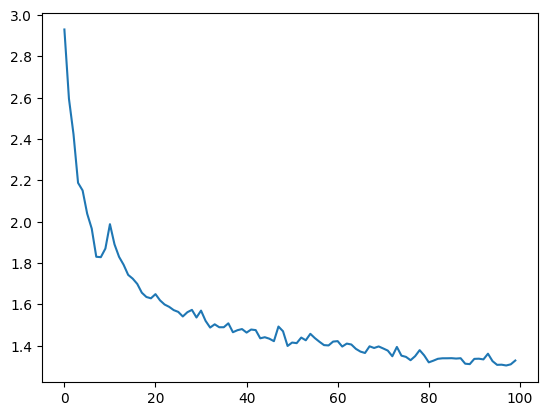

In [74]:
import matplotlib.pyplot as plt
plt.plot(loss_values)

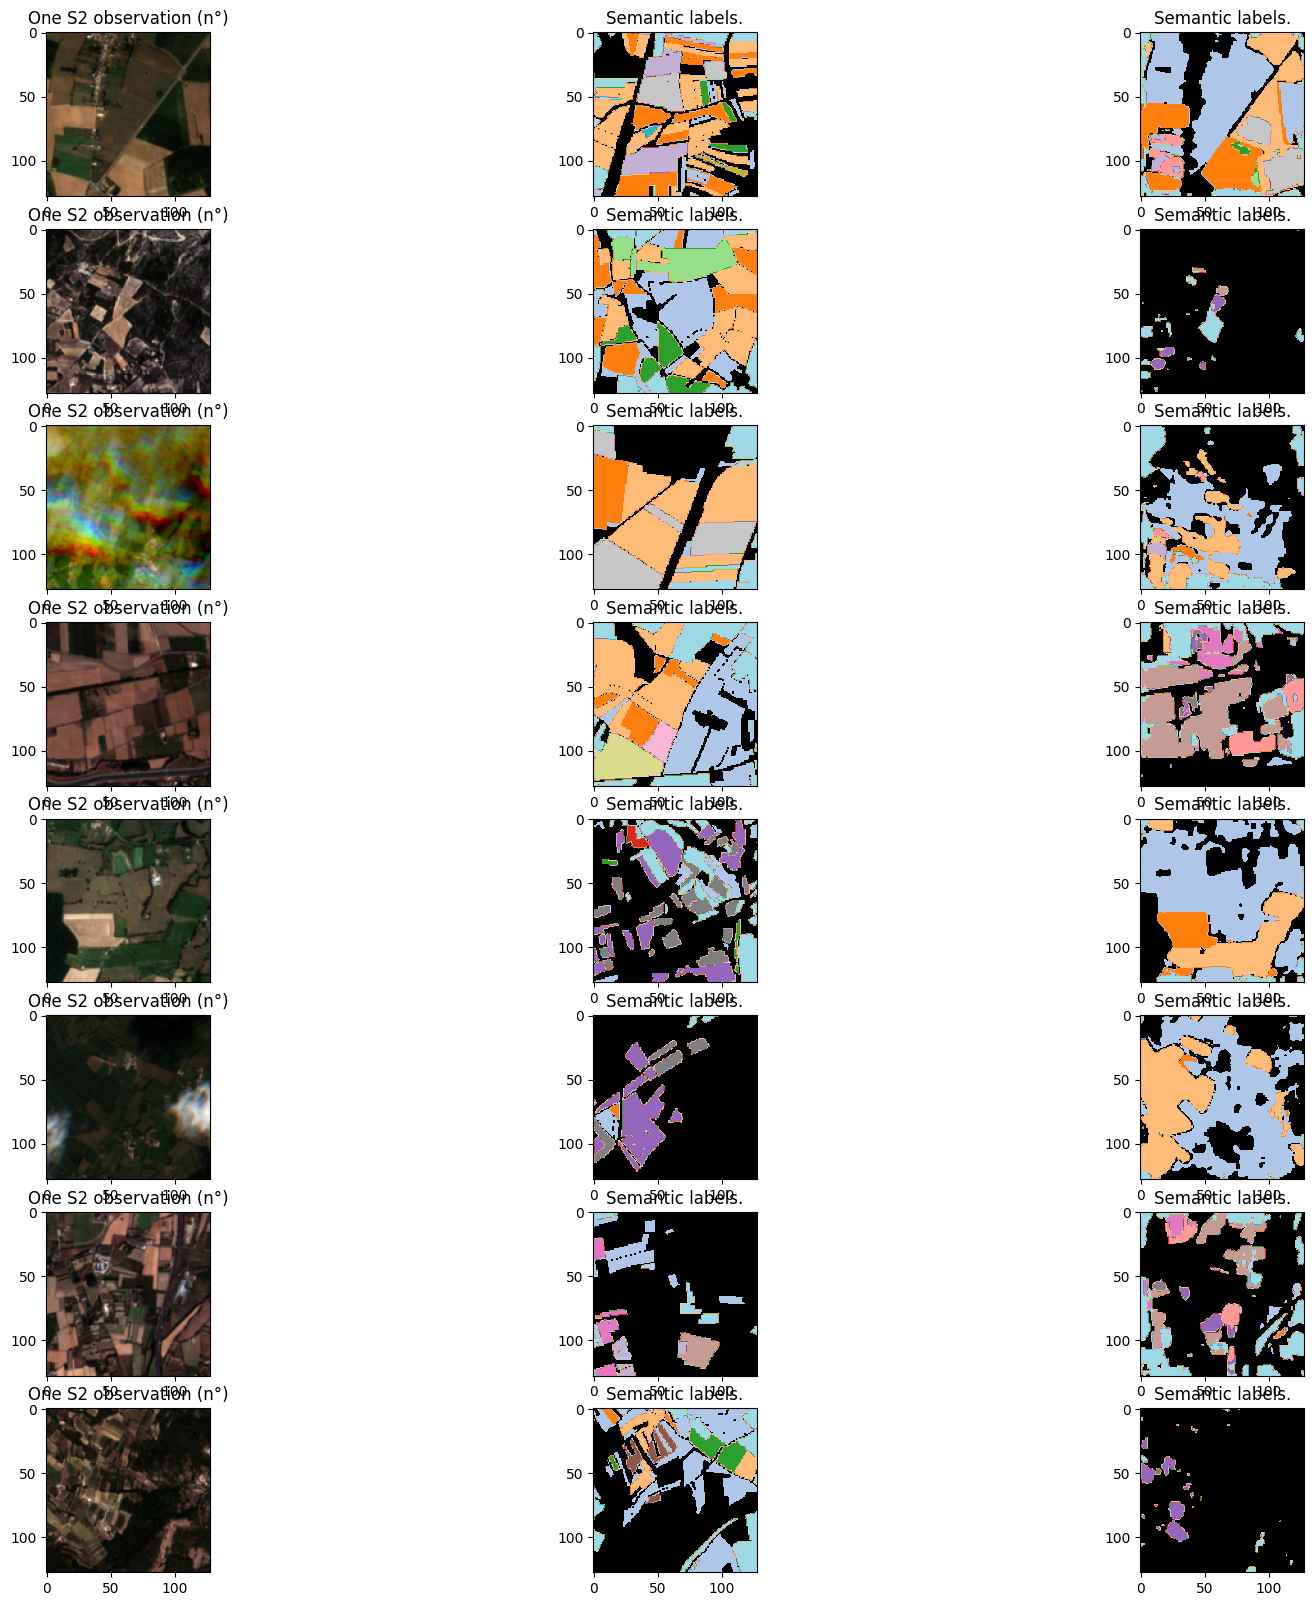

In [78]:
from baseline.viz import plot_s2_and_labels, get_rgb
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.colormaps.get_cmap("tab20")
def_colors = cm.colors
cus_colors = ["k"] + [def_colors[i] for i in range(1, 20)] + ["w"]
cmap = ListedColormap(colors=cus_colors, name="agri", N=21)

#x_train, y_train = train_loader.__iter__().__next__()
#input_preprocessed = preprocess_batch_august(x_train)

x_val, y_val = val_loader.__iter__().__next__()
input_preprocessed = preprocess_batch_august(x_val)

preds = model(input_preprocessed.to(device))
preds = preds.argmax(dim=1).cpu().numpy()

# Create subplots
fig, axes = plt.subplots(8, 3, figsize=(20, 20))

for bid in range(8):
    im = input_preprocessed[bid, [2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None]) / (mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)

    # Plot the Sentinel-2 RGB image
    axes[bid, 0].imshow(im)
    axes[bid, 0].set_title(f"One S2 observation (n°)")
 
    # Plobid, t the semantic labels
    axes[bid, 1].imshow(y_train[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
    axes[bid, 1].set_title("Semantic labels.")
 
    axes[bid, 2].imshow(preds[bid], cmap=cmap, vmin=0, vmax=20)
    axes[bid, 2].set_title("Semantic labels.")

# Show the plot
plt.show()

In [6]:
from sklearn.metrics import jaccard_score

def print_iou_per_class(
    targets: torch.Tensor,
    preds: torch.Tensor,
    nb_classes: int,
) -> None:
    """
    Compute IoU between predictions and targets, for each class.

    Args:
        targets (torch.Tensor): Ground truth of shape (B, H, W).
        preds (torch.Tensor): Model predictions of shape (B, nb_classes, H, W).
        nb_classes (int): Number of classes in the segmentation task.
    """

    # Compute IoU for each class
    # Note: I use this for loop to iterate also on classes not in the demo batch

    iou_per_class = []
    for class_id in range(nb_classes):
        iou = jaccard_score(
            targets == class_id,
            preds == class_id,
            average="binary",
            zero_division=0,
        )
        iou_per_class.append(iou)

    for class_id, iou in enumerate(iou_per_class):
        print(
            "class {} - IoU: {:.4f} - targets: {} - preds: {}".format(
                class_id, iou, (targets == class_id).sum(), (preds == class_id).sum()
            )
        )

def print_mean_iou(targets: torch.Tensor, preds: torch.Tensor) -> None:
    """
    Compute mean IoU between predictions and targets.

    Args:
        targets (torch.Tensor): Ground truth of shape (B, H, W).
        preds (torch.Tensor): Model predictions of shape (B, nb_classes, H, W).
    """

    mean_iou = jaccard_score(targets, preds, average="macro")
    print(f"meanIOU (over existing classes in targets): {mean_iou:.4f}")

In [7]:
score = 0.
for i, (inputs, targets) in tqdm(enumerate(val_loader)):
    inputs = preprocess_batch_august(inputs)
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1) # Get the predicted class per pixel (B, H, W)

    preds = preds.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()
    score +=jaccard_score(targets, preds, average="macro")

print(f"meanIOU (over existing classes in targets): {score / len(val_loader)}")

49it [00:49,  1.02s/it]

meanIOU (over existing classes in targets): 0.0382816998927298
